# 7. Vorlesung Nichtlineare Regelungstechnik 1

## Vorlesungsbeispiel zur Gleitregime-Regelung (Sliding-Mode-Control)

System:

\begin{align*}
\dot x_1(t) &= x_2\\
\dot x_2(t) &= -x_2^2(t) \cos(3 x_1(t)) + u(t).
\end{align*}

Für dieses System ist ein Gleitregime-Regler zu entwerfen, der den Koordinatenursprung stabilisiert. Es wird hier zunächst davon ausgegangen, dass das Systemmodell "perfekt" bekannt ist.

### Hinweise

Zu diesem Notebook gibt es noch zwei weitere:

- `nl1-v7-02-slidingmode-beispiel`: Erweiterung um Unbestimmtheiten im Systemmodell und Anti-Klapper-Vorrichtung
- `nl1-v7-03-slidingmode-beispiel`: Erweiterung um eine Trajektorienfolgeregelung

### Lösung

- Definition der Gleitfläche: 
  \begin{equation*}
  s(x_1, x_2) = x_2 + \lambda x_1 \qquad \text{mit} \qquad \lambda > 0
  \end{equation*}
  
  Es gilt:
  \begin{equation} \label{eq:sDot}
  \dot s(x_1, x_2) = \dot x_2 + \lambda \dot x_1 = -x_2^2 \cos(3 x_1) + u + \lambda x_2
  \end{equation}
  
- Gleitbedingung:
  \begin{equation*}
  \frac{1}{2} \frac{\text{d}}{\text{d}t} \left(s^2\right) =  s \dot s \stackrel{!}{\leq} \eta |s|
  \end{equation*}
  
  Mit dem Ausdruck für $\dot s$ ergibt sich:
  \begin{align*}
  -x_2^2 \cos(3 x_1) + u + \lambda x_2 \quad &
  \begin{cases}
  \stackrel{!}{\leq} - \eta &\text{für} \, s > 0\\
  \stackrel{!}{\geq} \hphantom{-} \eta &\text{für} \, s < 0
  \end{cases}\\
  u \quad &
  \begin{cases}
  \stackrel{!}{\leq} - \eta + x_2^2 \cos(3 x_1) - \lambda x_2 &\text{für} \, s > 0\\
  \stackrel{!}{\geq} \hphantom{-} \eta + x_2^2 \cos(3 x_1) - \lambda x_2  &\text{für} \, s < 0
  \end{cases}
  \end{align*}
  
- Resultierender Regler:
  \begin{equation*}
  u = -\eta \cdot \text{sgn}(s) + x_2^2 \cos(3 x_1) - \lambda x_2
  \end{equation*}
  

---

Die aktuelle Fassung dieses Notebooks findet sich in folgendem Repositorium:

https://gitlab.hrz.tu-chemnitz.de/rst/public/teaching/nl1-nbviewer-content

Sie können zur Entwicklung/ Verbesserung über Merge Requests beitragen!

---

<p style="font-family:Courier New; font-size:10pt">
Copyright (c) 2022-2023 Jan Winkler, TU Dresden, Germany
</p>

<p style="font-family:Courier New; font-size:10pt">
This program is free software: you can redistribute it and/or modify<br>
it under the terms of the GNU General Public License as published by<br>
the Free Software Foundation, either version 3 of the License, or<br>
(at your option) any later version.
</p>
    
<p style="font-family:Courier New; font-size:10pt">
This program is distributed in the hope that it will be useful,<br>
but WITHOUT ANY WARRANTY; without even the implied warranty of<br>
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the<br>
GNU General Public License for more details: <br>
<a href=https://www.gnu.org/licenses/gpl-3.0.txt>https://www.gnu.org/licenses/gpl-3.0.txt</a>.
</p>

---

## Vorbereitung der Simulation

Die Simulation läuft folgender Maßen ab:

- Der Regelalgorithmus läuft zeitdiskret und wird alle `t_sample` Sekunden aufgerufen.
- Zwischen den Abtastschritten wird das zu regelnde System zeitkontinuierlich mit variabler Schrittweite simuliert.
- Um einen visuell glatten Verlauf zu erhalten, kann über den Parameter `refine_factor` festgelegt werden, an wieviel
  Zeitpunkten zwischen den Abtastschritten die zeitkontierliche Simulation ausgewertet werden soll.

### Import benötigter Module

In [1]:
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt

### Simulationsparameter

In [2]:
# Anfangsbedingungen
x10 = 2
x20 = 0

# Simulationsdauer
t_sim = 10

# Abtastzeit Regler
t_sample = 0.1

# Anzahl der Auswertungen des zeitkont. Systems zwischen den Abtastschritten
refine_factor = 10

### Reglerparameter

Das Regelgesetz hat zwei Parameter:

- $\lambda$: Legt die Lage der Gleitfläche in der $x_1$-$x_2$-Ebene fest und bestimmt, mit welcher Zeitkonstanten der Einlauf in die Ruhelage auf der Gleitfläche erfolgt (im rein zeitkontinuerlichen Fall).
- $\eta$: Legt fest, wie schnell die Überführung auf die Gleitfläche erfolgt. Außerdem beeinflusst der Parameter, wie stark die Stellgröße einwirkt.

**Tipp:** Variieren Sie die Parameter, um den Einfluss zu evaluieren.

In [3]:
plambda = 2
peta = 1

## Definition benötigter Funktionen

### Rechte Seite des Systemdifferentialgleichungssystems

Die nachfolgende Funktion wird weiter unten dem numerischen Differenzialgleichungslöser übergeben.

In [4]:
def dgl_sys(t, x, u):
    """
    Implementation der rechten Seite des Differentialgleichungssystems
    """
    x1, x2 = x

    x1_dot = x2
    x2_dot = -x2**2 * np.cos(3 * x1) + u

    return [x1_dot, x2_dot]

### Regelgesetz

Das oben hergeleitete Regelgesetz, welches zu den Abtastzeitpunkten aufgerufen wird.

In [5]:
def sliding_mode_controller(x, para_lambda, para_eta):
    """
    Implementierung des Regelgesetzes
    """
    x1, x2 = x

    s = x2 + para_lambda * x1

    return -para_eta * np.sign(s) + x2**2 * np.cos(3 * x1) - para_lambda * x2

## Durchführung der Simulation

- Die Variablen `t_control_steps`, `x_control_steps` `u_control_steps` halten die Verläufe von Zeit, Zustand und Stellgröße für das abgetastete System.
- `t_cont` und `x_cont` halten den Zeitverlauf und den Verlauf des Zustands des zeitkontinuierlichen Systems. Diese werden nach jedem Abtastschritt um den zeitkontinuerliche simulierten Abschnitt ergänzt. Die Implementierung ist nicht sehr effizient, aber zur Veranschaulichung ist es so einfacher. In den Notebooks zur Übung ist eine effizientere Lösung angegeben.
- Für die zeitkontinuierliche Simulation wird `solve_ivp` aus dem SciPy-Paket genutzt ([Dokumentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html)).
- Da der Löser die rechte Seite der Dgl. mit der Signatur `t, x` erwartet, diese hier aber `t, x, u` lautet, wird die Funktion `dgl_sys` über eine lambda-Funktion  übergeben (Matlab: `@`). Damit erscheint `dgl_sys` wie mit der Signatur `t, x`, es wird aber sichergestellt, dass `u` auch mit einem Wert belegt wird, nämlich dem aktuellen Stellwert `u_act`.

In [6]:
# Zeitdiskretes System
t_control_steps = np.arange(0, t_sim + t_sample, t_sample)
x_control_steps = np.zeros((2, t_control_steps.size))  # 2 Zeilen, soviel Spalten wie Schritte
u_control_steps = np.zeros(t_control_steps.size)

# Zeitkontinuierliches System
t_cont = np.array([])
x_cont = np.ndarray((2, 0))

# Zustand im aktuellen Abtastschritt
x_act = [x10, x20]

for i, t_act in enumerate(t_control_steps):
    
    # Aktueller Zustand des abgetasteten Systems = Endzustand der
    # letzten zeitkontinuierlichen Simulation
    x_control_steps[:, i] = x_act

    # Regelgesetz auswerten
    u_act = sliding_mode_controller(x_act, plambda, peta)
    u_control_steps[i] = u_act

    # Simulation der Regelstrecke von t_act -> t_act + t_sample
    sol = sci.solve_ivp(lambda t, x: dgl_sys(t, x, u_act), [t_act, t_act + t_sample], x_act, 
                        t_eval=np.linspace(t_act, t_act + t_sample, refine_factor))

    # Letztes Element der Lösung ist der aktuelle Zustand im nächsten Schritt
    x_act = sol.y[:, -1]

    # An die bestehenden Verläufe die neu simulierten anhängen
    # Sehr arbeitsintensiv auf dem Speicher! (für dieses einfache Beispiel irrelevant,
    # aber bei komplexeren Aufgaben kann es problematisch werden)
    t_cont = np.hstack((t_cont, sol.t[0:-1]))
    x_cont = np.hstack((x_cont, sol.y[:, 0:-1]))

## Darstellung der Ergebnisse

Trajektorie in der $x_1$-$x_2$-Ebene. Die roten Punkte markieren die Stellen, an den die Stellgröße neu berechnet wurde. Die gerade Linie ist die Gleitfläche

`%matplotlib widget` entkommentieren für bessere Grafiken (erfordert ipywidgets)

Text(0, 0.5, '$x_2$')

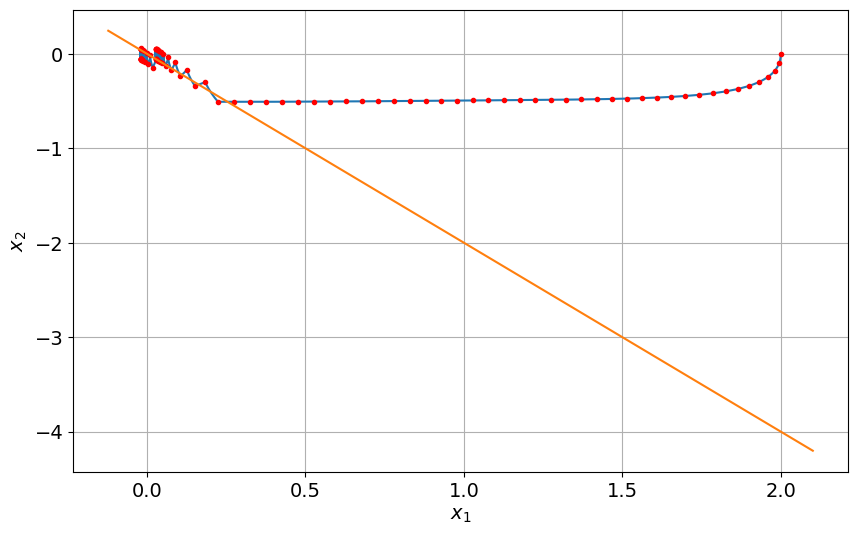

In [7]:
#%matplotlib widget
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(10, 6))

# Trajektorie Zustand
plt.plot(x_cont[0, :], x_cont[1, :])

# Abtastpunkte
plt.plot(x_control_steps[0, :], x_control_steps[1, :], '.', color='r')

# Gleitfläche
x1_sl = np.array(plt.xlim())
x2_sl = -plambda * x1_sl
plt.plot(x1_sl, x2_sl)

plt.grid()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

Zeitverläufe

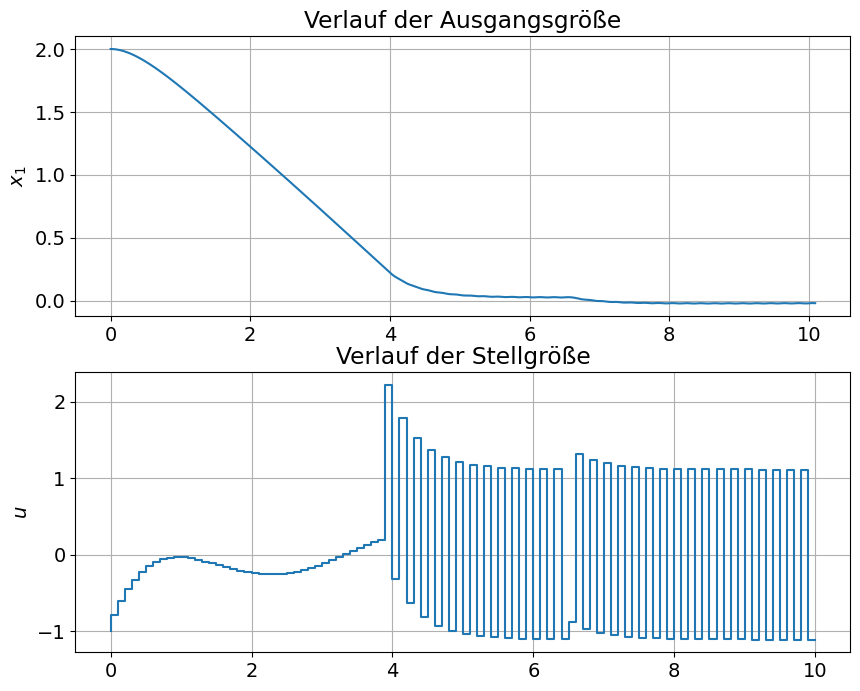

In [8]:
fig = plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot(t_cont, x_cont[0,:])
plt.title('Verlauf der Ausgangsgröße')
plt.ylabel('$x_1$')
plt.grid()

plt.subplot(212)
plt.step(t_control_steps, u_control_steps)
plt.title('Verlauf der Stellgröße')
plt.ylabel('$u$')
plt.grid()

#fig.subplots_adjust(hspace=0.3)